### Imports + preprocessing (augmentation and normalization)

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import zipfile
import time
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

In [47]:
import matplotlib.pyplot as plt
import shutil
import os
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [4]:
! pip install -q kaggle

In [ ]:
# kaggle token
from google.colab import files
files.upload()

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset
with zipfile.ZipFile("augmented-alzheimer-mri-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("alzheimer_dataset")

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
 88% 334M/380M [00:00<00:00, 597MB/s]
100% 380M/380M [00:00<00:00, 542MB/s]


#### Augmentation

In [8]:
img_height = 224
img_width = 224
target_per_class = 3000 # for better balanced classes
batch_size = 32
class_count = 4

In [14]:
original_dataset_dir = 'alzheimer_dataset/OriginalDataset'
augmented_dataset_dir = 'augmented_dataset'
os.makedirs(augmented_dataset_dir, exist_ok=True)

# for MildDemented and ModerateDemented (they have too little images)
classes_to_augment = {
    'ModerateDemented': 'alzheimer_dataset/OriginalDataset/ModerateDemented',
    'MildDemented': 'alzheimer_dataset/OriginalDataset/MildDemented',
    'VeryMildDemented': 'alzheimer_dataset/OriginalDataset/VeryMildDemented' # making it also 3000 samples
}

In [23]:
augmented_base_dir = 'temp'
os.makedirs(augmented_base_dir, exist_ok=True)

augmentor = ImageDataGenerator(
    rotation_range=15, # randomly rotate by 15 degress
    width_shift_range=0.1, # shift horizontally
    height_shift_range=0.1, # shift vertically
    zoom_range=0.2, # zoom 20%
    horizontal_flip=True, # flip horizontally
    fill_mode='nearest' # fills empty pixels (that occur after flipping) on img with nearest pixels
)

for class_name, input_dir in classes_to_augment.items():
    output_dir = os.path.join(augmented_base_dir, class_name)
    os.makedirs(output_dir, exist_ok=True)

    # copy original images
    originals = [f for f in os.listdir(input_dir) if f.lower().endswith('.jpg')]
    for fname in originals:
        src = os.path.join(input_dir, fname)
        dst = os.path.join(output_dir, fname)
        if not os.path.exists(dst):
            img = load_img(src)
            img.save(dst)

    generated = 0
    i = 0
    total_samples_needed = max(0, target_per_class - len(originals))

    while generated < total_samples_needed:
        img_path = os.path.join(input_dir, originals[i % len(originals)])
        img = load_img(img_path, target_size=(img_height, img_width))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0) # batch

        for batch in augmentor.flow(x, batch_size=1):
            aug_path = os.path.join(output_dir, f"aug_{generated}.jpg")
            save_img(aug_path, batch[0])
            generated += 1
            break  # after image has been augmented

In [24]:
# merge datasets
original_dirs = {
    'NonDemented': 'alzheimer_dataset/OriginalDataset/NonDemented'
}
augmented_dirs = {
    'MildDemented': 'temp/MildDemented',
    'ModerateDemented': 'temp/ModerateDemented',
    'VeryMildDemented': 'temp/VeryMildDemented'
}

final_base = 'augmented_ds'

def copy_images(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for fname in os.listdir(src_dir):
        if fname.lower().endswith(('.jpg')):
            src = os.path.join(src_dir, fname)
            dst = os.path.join(dst_dir, fname)
            shutil.copy(src, dst)

for label, path in original_dirs.items():
    copy_images(path, os.path.join(final_base, label))

for label, path in augmented_dirs.items():
    copy_images(path, os.path.join(final_base, label))

In [25]:
# delete temp
shutil.rmtree('temp')

In [26]:
base_dir = 'augmented_ds'

filepaths = []
labels = []

for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, fname))
            labels.append(label)
alzheimer_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

print('Labels and number of photos')
print('-'*10)
print(alzheimer_df["labels"].value_counts())

Labels and number of photos
----------
labels
NonDemented         3200
ModerateDemented    3000
MildDemented        3000
VeryMildDemented    3000
Name: count, dtype: int64


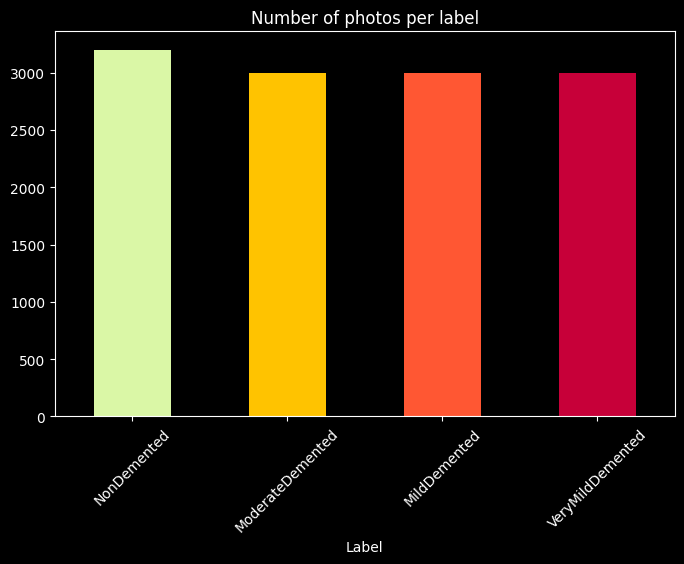

In [27]:
counts = alzheimer_df['labels'].value_counts()

colors = ['#DAF7A6', '#FFC300', '#FF5733', '#C70039']
counts.plot(kind='bar', color=colors, figsize=(8,5))

plt.title("Number of photos per label")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.style.use('dark_background')
plt.show()

#### Normalization

In [28]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 7808 validated image filenames belonging to 4 classes.
Found 1952 validated image filenames belonging to 4 classes.
Found 2440 validated image filenames belonging to 4 classes.


In [46]:
class_names = list(test_generator.class_indices.keys())
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [72]:
# confusion matrix
def evaluate_model(generator, model, class_names):

    y_pred_probs = model.predict(generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    print("Classification Report:")
    print("-"*50)
    print(classification_report(y_true, y_pred, target_names=class_names))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='magma')
    plt.title("Confusion Matrix")
    plt.show()

    return cm

#### ResNet50

In [29]:
input_shape = (img_height, img_width, 3)
resnet50 = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50.trainable = False
x = resnet50.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(class_count, activation='softmax')(x)
model_rn = Model(inputs=resnet50.input, outputs=outputs)

model_rn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
training_start_time_r = time.time()
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) # stops if validation loss doesnt get better in next 2 epochs
history_r = model_rn.fit(train_generator,
                    validation_data = val_generator,
                    epochs=20, # trying with more epochs but with early stopping
                    callbacks=[early_stop])
training_end_time_r = time.time()

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


244/244 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - accuracy: 0.6223 - loss: 0.9059 - val_accuracy: 0.7874 - val_loss: 0.4803
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.7966 - loss: 0.4727 - val_accuracy: 0.8028 - val_loss: 0.4382
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - accuracy: 0.8133 - loss: 0.4364 - val_accuracy: 0.8279 - val_loss: 0.4115
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - accuracy: 0.8369 - loss: 0.3885 - val_accuracy: 0.8284 - val_loss: 0.3865
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.8496 - loss: 0.3572 - val_accuracy: 0.8581 - val_loss: 0.3445
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.8663 - loss: 0.3201 - val_accuracy: 0.8617 - val_loss: 0.3303
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - accuracy: 0.8707 - loss: 0.3197 - val_accuracy: 0.8735 - val_loss: 0.3126
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.8788 - loss: 0.3048 - val

In [33]:
resnet50_time = training_end_time_r - training_start_time_r
test_loss, resnet50_accuracy = model_rn.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_accuracy:.4f}')
print(f'Training took {resnet50_time / 60:.2f} minutes')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.8696 - loss: 0.3148
--------------------------------------------------
Test accuracy: 0.8697
Training took 5.98 minutes


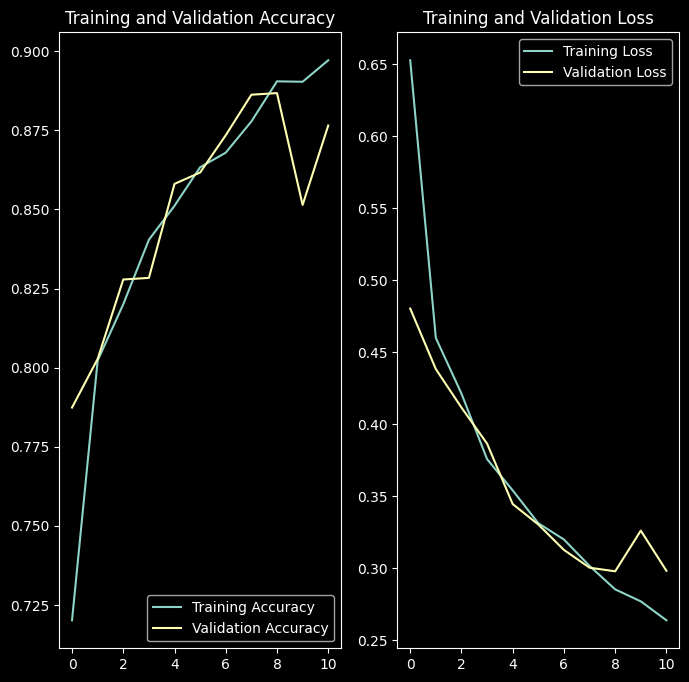

In [37]:
acc = history_r.history['accuracy']
val_acc = history_r.history['val_accuracy']

loss = history_r.history['loss']
val_loss = history_r.history['val_loss']

epochs_range = range(11)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step
Classification Report:
--------------------------------------------------
                  precision    recall  f1-score   support

    MildDemented       0.98      0.75      0.85       600
ModerateDemented       0.99      0.99      0.99       600
     NonDemented       0.89      0.83      0.86       640
VeryMildDemented       0.70      0.91      0.79       600

        accuracy                           0.87      2440
       macro avg       0.89      0.87      0.87      2440
    weighted avg       0.89      0.87      0.87      2440



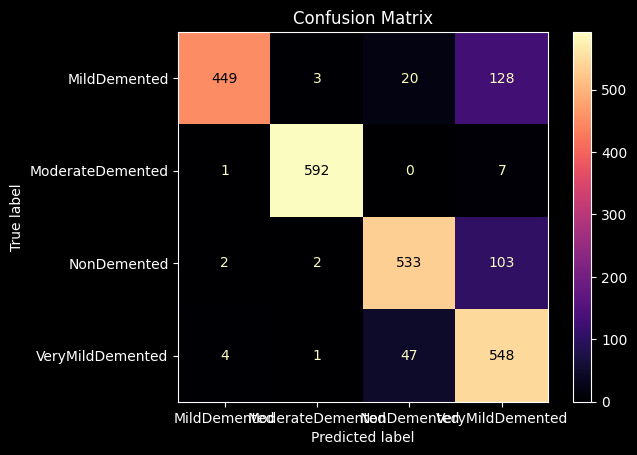

In [73]:
cm_resnet50 = evaluate_model(test_generator, model=model_rn, class_names=class_names)

### MobileNet

In [62]:
input_shape = (img_height, img_width, 3)
mobilenet = MobileNet(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
mobilenet.trainable = False
x = mobilenet.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(class_count, activation='softmax')(x)
model_mn = Model(inputs=mobilenet.input, outputs=outputs)

model_mn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [63]:
training_start_time_n = time.time()
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history_n = model_mn.fit(train_generator,
                    validation_data = val_generator,
                    epochs=20,
                    callbacks=[early_stop])
training_end_time_n = time.time()

Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.6446 - loss: 0.9014 - val_accuracy: 0.8699 - val_loss: 0.4362
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.8687 - loss: 0.4156 - val_accuracy: 0.8899 - val_loss: 0.3490
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.8898 - loss: 0.3503 - val_accuracy: 0.8904 - val_loss: 0.3143
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.8981 - loss: 0.3070 - val_accuracy: 0.8996 - val_loss: 0.2954
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9007 - loss: 0.2768 - val_accuracy: 0.8852 - val_loss: 0.2861
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.9037 - loss: 0.2657 - val_accuracy: 0.9073 - val_loss: 0.2674
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.9028 - loss: 0.2654 - val_accuracy: 0.9129 - val_loss: 0.2787
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9186 - loss: 0.2364 - 

In [64]:
mobilenet_time = training_end_time_n - training_start_time_n
test_loss, mobilenet_accuracy = model_mn.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {mobilenet_accuracy:.4f}')
print(f'Training took {mobilenet_time / 60:.2f} minutes')

77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8997 - loss: 0.2453
--------------------------------------------------
Test accuracy: 0.9094
Training took 3.88 minutes


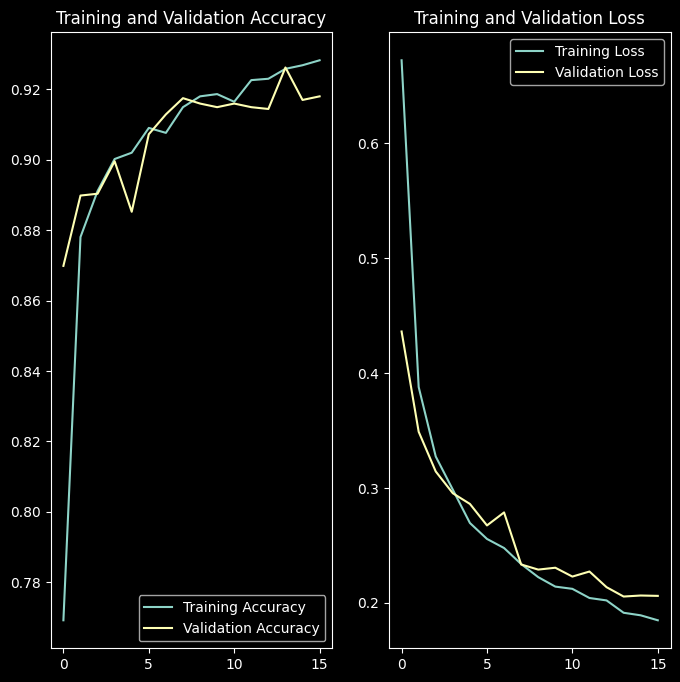

In [70]:
acc = history_n.history['accuracy']
val_acc = history_n.history['val_accuracy']

loss = history_n.history['loss']
val_loss = history_n.history['val_loss']

epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
Classification Report:
--------------------------------------------------
                  precision    recall  f1-score   support

    MildDemented       0.92      0.79      0.85       600
ModerateDemented       1.00      0.97      0.99       600
     NonDemented       0.97      0.96      0.96       640
VeryMildDemented       0.77      0.92      0.84       600

        accuracy                           0.91      2440
       macro avg       0.92      0.91      0.91      2440
    weighted avg       0.92      0.91      0.91      2440



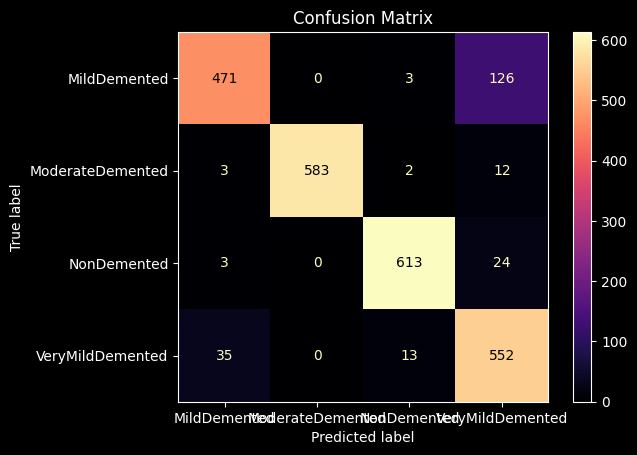

In [74]:
cm_mobilenet = evaluate_model(test_generator, model=model_mn, class_names=class_names)

#### Saving better model (91% accuracy)

In [78]:
model_mn.save('best_model.keras')
from google.colab import files
files.download('best_model.keras') # saving it locally to push to repo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>